In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import os
import seaborn as sns
from proj1_helpers import *


## Load the training data into feature matrix, class labels, and event ids:

## WE NEED TO CHANGE THE DATA PATH

In [ ]:
DATA_TRAIN_PATH = r'C:/Users/soria/Google Drive/Machine Learning/project1/data/train.csv' # TODO: download train data and supply path here 
DATA_TEST_PATH = r'C:/Users/soria/Google Drive/Machine Learning/project1/data/test.csv' # TODO: download test data and supply path here 

In [2]:
y, tx, ids = load_csv_data(DATA_TRAIN_PATH)
print(y.shape)
print(tx.shape)
print(ids.shape)

(250000,)
(250000, 30)
(250000,)


## 1) EXPLORATORY DATA ANALYSIS 

*Check loaded values*

In [3]:
y

array([ 1., -1., -1., ...,  1., -1., -1.])

In [4]:
tx

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [5]:
ids

array([100000, 100001, 100002, ..., 349997, 349998, 349999])

In [6]:
print(np.max(tx), np.min(tx))

4974.979 -999.0


*Observe values together in a heatmap*

Text(0.5, 1.0, 'Feature visualization')

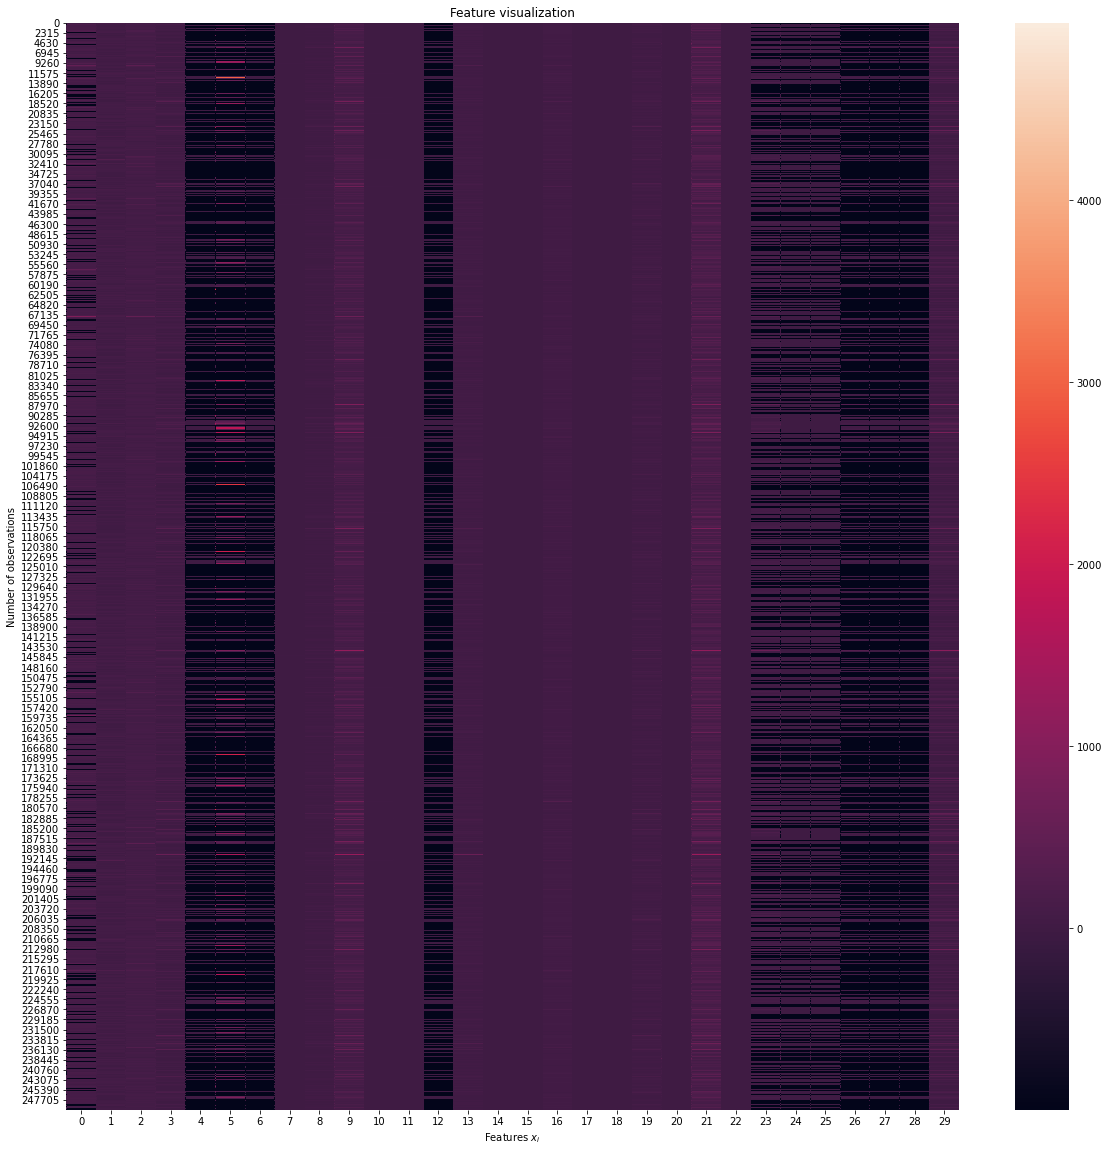

In [7]:
plt.figure(figsize=(20,20))

sns.heatmap(tx)

plt.xlabel('Features $x_{i}$')
plt.ylabel('Number of observations')
plt.title('Feature visualization')

Text(0.5, 1.0, 'Feature visualization')

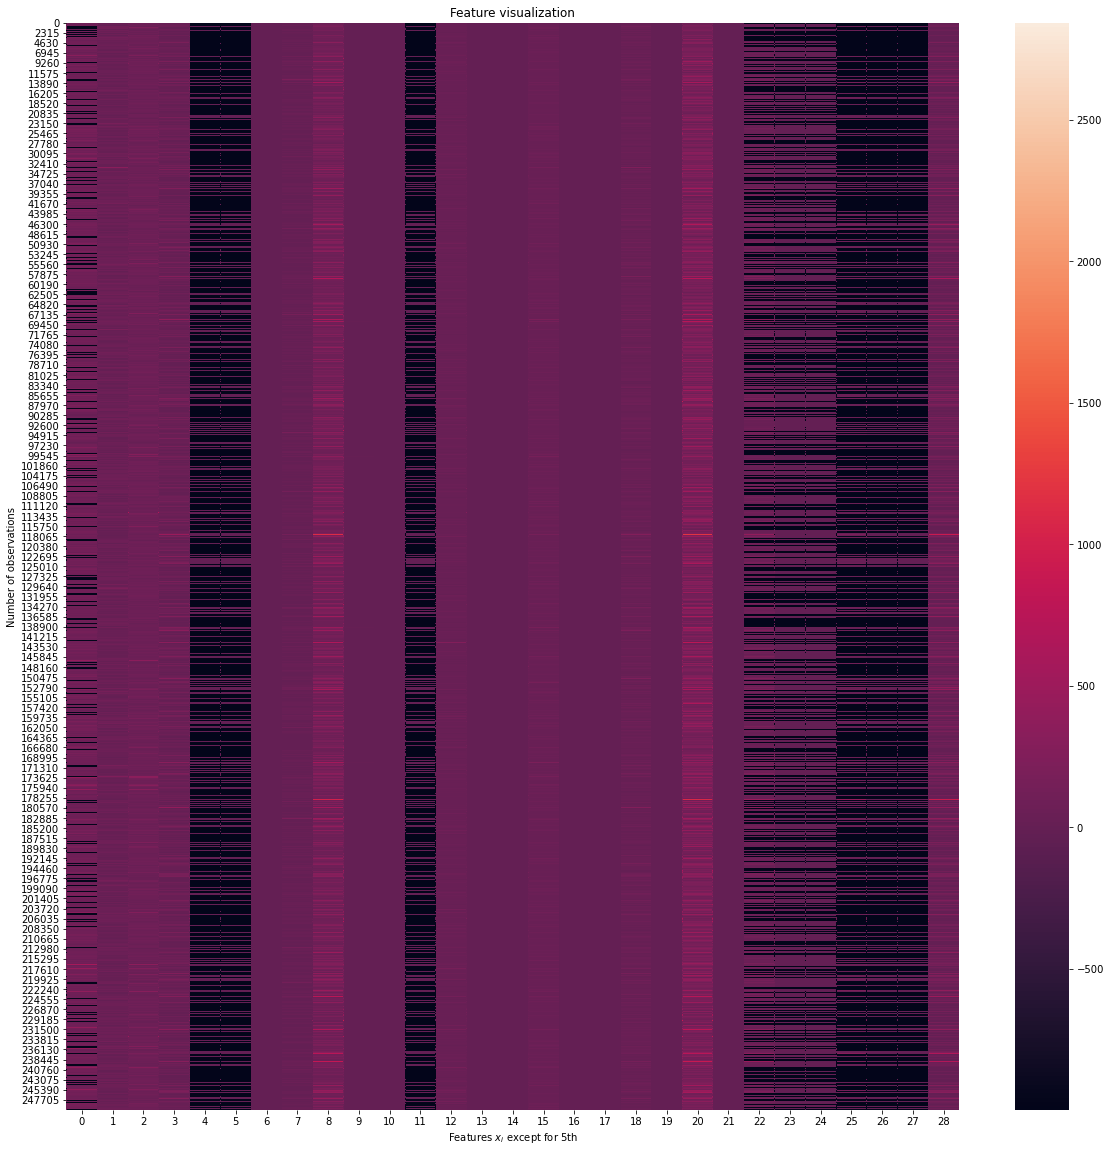

In [8]:
# this is removing column = 5 which had suuper high values

tx_del = np.delete(tx, 5, 1)
plt.figure(figsize=(20,20))

sns.heatmap(tx_del)

plt.xlabel('Features $x_{i}$ except for 5th')
plt.ylabel('Number of observations')
plt.title('Feature visualization')

*Look at distributions for each feature*

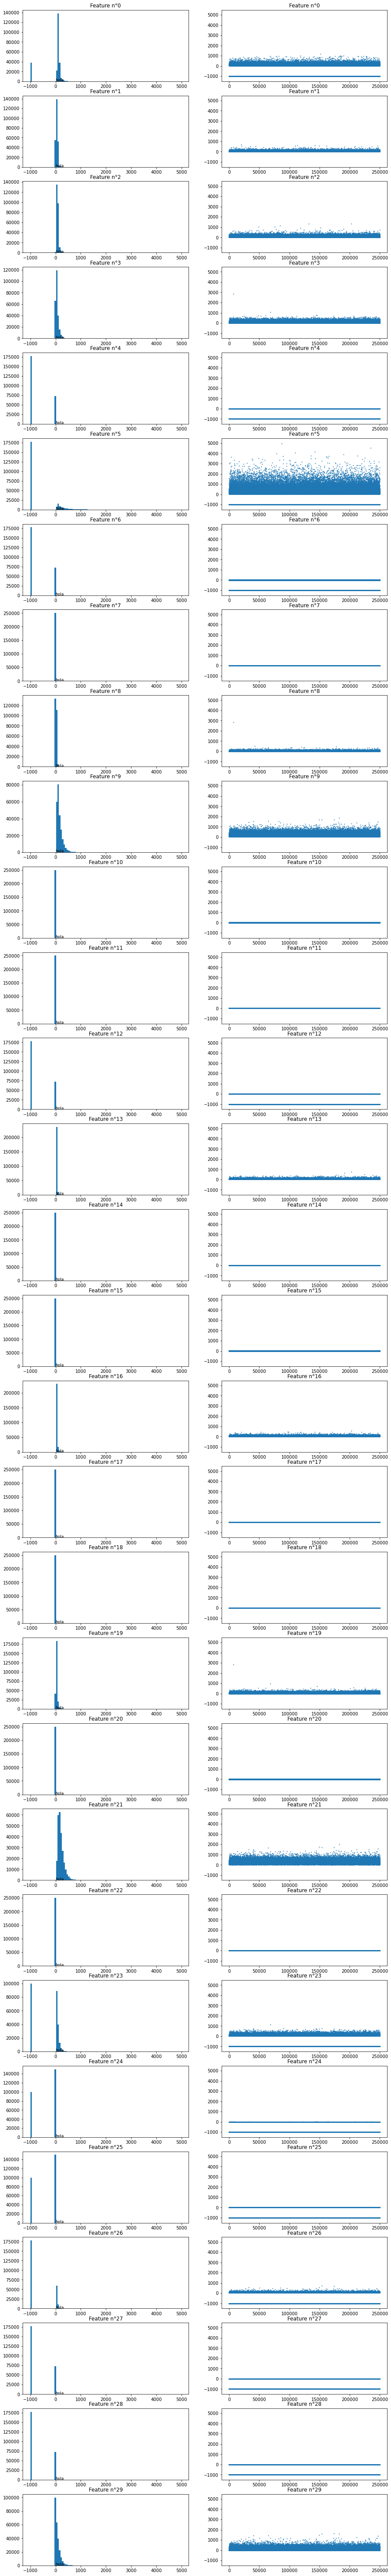

In [10]:
fig, ax = plt.subplots(30,2,figsize=(15,108))
obser = range(tx.shape[0])
for i in range(tx.shape[1]):  
    ax[i][0].hist(tx[:,i],bins=100, range=[np.min(tx),np.max(tx)])
    ax[i][0].title.set_text('Feature n°{}' .format(i))
    
    ax[i][1].scatter(obser,tx[:,i],s=1)
    ax[i][1].title.set_text('Feature n°{}' .format(i))
    ax[i][1].set_ylim(np.min(tx)-500,np.max(tx)+500)

**Observations**
- In this lab, a vector of features representing the decay signature of a collision event, is provided as tx.
- The features are produced by simulating a proton-proton collision and "measuring" the resulting particles.
- There are features that can take either of two values: 0 and -1000, it looks that they are 'categorical' features, which belong to one category and do not exist continuously.
- There are features that always take the same value: 0. Are they useful? Probably not, we could think of removing them?
- There are features with a great variance around the 0 value. Does this affect the predictions and make it easier to predict incorrectly the output? Should we treat them? Either removing or making them narrower? This could be interpretted as being a continuous feature? Or a mistake around 0?
- In general the values around -1000 have a small variance, so OK.


*Now, we look at the similarity between features, for this purpuse we could use:*
- MSE: to see the immediate resemblance between two features
- t-test
- p-value: to check the statistical similarity between two features

In [11]:
import scipy
mse_all = np.zeros([tx.shape[1],tx.shape[1]])
tvalues_all = np.zeros([tx.shape[1],tx.shape[1]])
pvalues_all = np.zeros([tx.shape[1],tx.shape[1]])
for i in range(tx.shape[1]):
    ti = tx[:,i]
    for j in range(tx.shape[1]):
        tj = tx[:,j]
        mse = np.square(np.subtract(ti,tj)).mean()        
        tvalue,pvalue = scipy.stats.ttest_ind_from_stats(np.mean(ti), np.std(ti), len(ti), np.mean(tj), np.std(tj), len(tj))
        mse_all[i,j] = mse
        tvalues_all[i,j] = tvalue
        pvalues_all[i,j] = pvalue

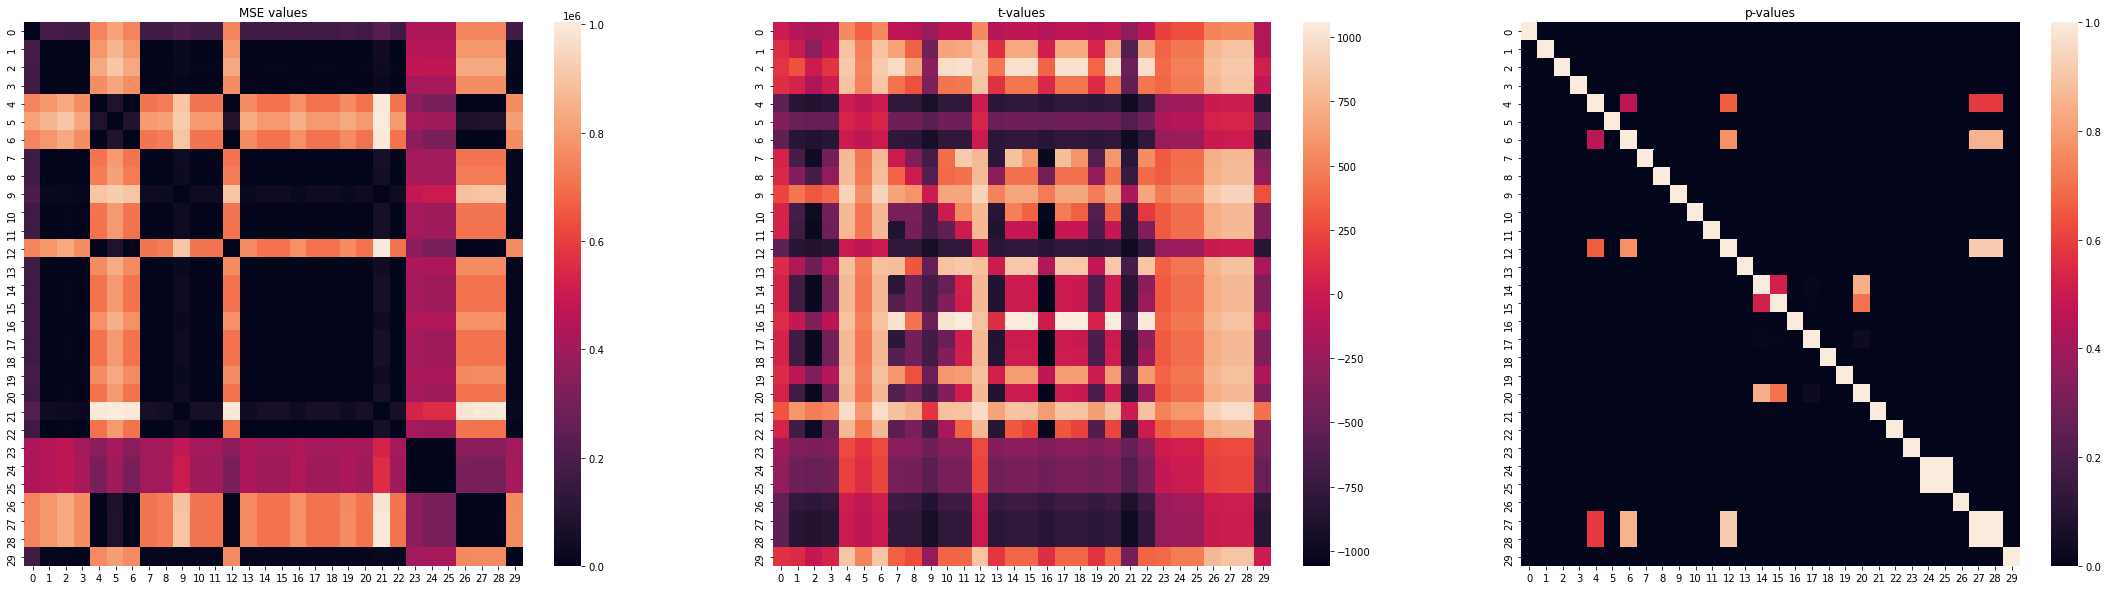

In [12]:
fig, ax = plt.subplots(1,3,figsize=(38,10))
sns.heatmap(mse_all,ax=ax[0])
ax[0].title.set_text('MSE values')
sns.heatmap(tvalues_all,ax=ax[1])
ax[1].title.set_text('t-values')
sns.heatmap(pvalues_all,ax=ax[2])
ax[2].title.set_text('p-values')


**Observations**
- You can see that MSE is almost 0 for all those features that do not give a lot of information because they are always giving 
values around 0
- There are some features that have a really high (close to 1) p-value, and that indicates statistical similarity, maybe it is
not interesting to have them both, or we could combine them
- T-values give similar information, they are very high in absolute value, so that indicates that both features are very different in terms of statistical similarity

## 2) FEATURE PROCESSING ##

*Taking into account the information obtained in the previous section ( 1) Exploratry data analysis ) we can modify data as 
we want. We could meet one day and discuss it :)*

## 3) IMPLEMENT THE ML METHODS

In [27]:
def compute_error(y, tx, w):
    e = y-np.matmul(tx,w)
    return e

def compute_loss(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    mse = 1/(2*N)*np.sum(e**2)
    rmse = np.sqrt(2*mse)
    return rmse

In [28]:
def compute_gradient(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    grad = (-1/N)*np.matmul(tx.T,e)
    return grad

def gradient_descent(y, tx, initial_w, max_iters, gamma):
    #ws = [initial_w]
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        w -= gamma*grad
        #ws.append(w)
        #losses.append(loss)
        #print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              #bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    loss = compute_loss(y, tx, w) #rmse
    return w, loss

In [21]:
def compute_stoch_gradient(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    grad = (-1/N)*np.matmul(tx.T,e)
    return grad


def stochastic_gradient_descent(y, tx, initial_w, max_iters, gamma,  batch_size = 1):
    #ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        for ymini, txmini in batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
            grad = compute_gradient(ymini, txmini, w)
            #loss = compute_loss(ymini, txmini, w)
            w -= gamma*grad
            #ws.append(w)
        #print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              #bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    loss = compute_loss(ymini, txmini, w) #rmse
    return w, loss

In [22]:
def least_squares(y, tx):
    N = len(y)
    w = np.linalg.solve(np.matmul(tx.T, tx), np.matmul(tx.T,y))
    loss = compute_loss(y, tx, w) #rmse
    return w, loss

In [23]:
def ridge_regression(y, tx, lambda_ = 0.3):
    N=len(tx)
    lambda_acc=2*N*lambda_
    kwad = np.matmul(tx.T,tx)
    w = np.linalg.solve(kwad+lambda_acc*np.eye(kwad.shape[0]),np.matmul(tx.T,y))
    loss = compute_loss(y, tx, w) #rmse
    return w, loss

**Determine whether a ML method overfits / underfits by looking at:**
- train / test rmse
- plot data and calculated function
- bias and variance

In [88]:
y_train, tx_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
y_test, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

**Train / test rmse**

# we are not doing feature expansion, are we? should we?
then these things should be done for all methods and probably plot them together to see them together

In [29]:
"LS, GD, SGD, RR methods"

weights_lse, loss_lse_train = least_squares(y_train, tx_train)
#weights_gd, loss_gd_train = gradient_descent(y_train, tx_train, initial_w=np.ones(tx_train.shape[1]), max_iters=1000, gamma=0.1)
#weights_sgd, loss_sgd_train = stochastic_gradient_descent(y_train, tx_train, initial_w=np.ones(tx_train.shape[1]), max_iters=1000, gamma=0.1)
weights_rr, loss_rr_train = ridge_regression(y_train, tx_train)

y_pred_lse = predict_labels(weights_lse, tx_test)
#y_pred_gd = predict_labels(weights_gd, tx_test)
#y_pred_sgd = predict_labels(weights_sgd, tx_test)
y_pred_rr = predict_labels(weights_rr, tx_test)

loss_lse_test = compute_loss(y_pred_lse, tx_test, weights_lse)
#loss_gd_test = compute_loss(y_pred_gd, tx_test, weights_gd)
#loss_sgd_test = compute_loss(y_pred_sgd, tx_test, weights_sgd)
loss_rr_test = compute_loss(y_pred_rr, tx_test, weights_rr)

# WE WILL SEE ACTUAL Y_TRAIN AND PREDICTION F_TRAIN FOR THE SAME TX_TRAIN TO SEE HOW WELL "OVERFTTED" or not IS IT
f_lse = predict_labels(weights_lse, tx_train)
#f_gd = predict_labels(weights_gd, tx_train)
#f_sgd = predict_labels(weights_sgd, tx_train)
f_rr = predict_labels(weights_rr, tx_train)

methods = ['LS','GD','SGD','RR']
loss_train=[loss_lse_train,0,0,loss_rr_train]
loss_test = [loss_lse_test,0,0,loss_rr_test]

**Plot RMSE**

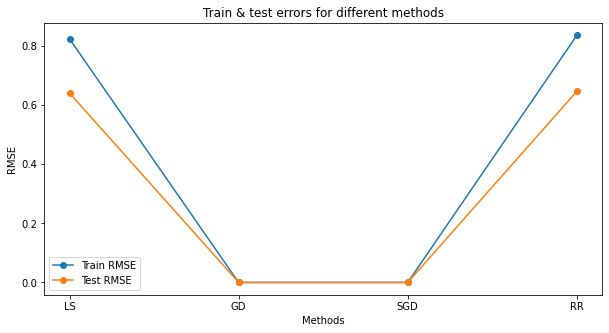

In [39]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(methods,loss_train,'o-')
plt.plot(methods, loss_test,'o-')

plt.legend(["Train RMSE", "Test RMSE"])
plt.title('Train & test errors for different methods')
plt.xlabel('Methods')
plt.ylabel('RMSE')
plt.show()

**Plot data and calculated function**

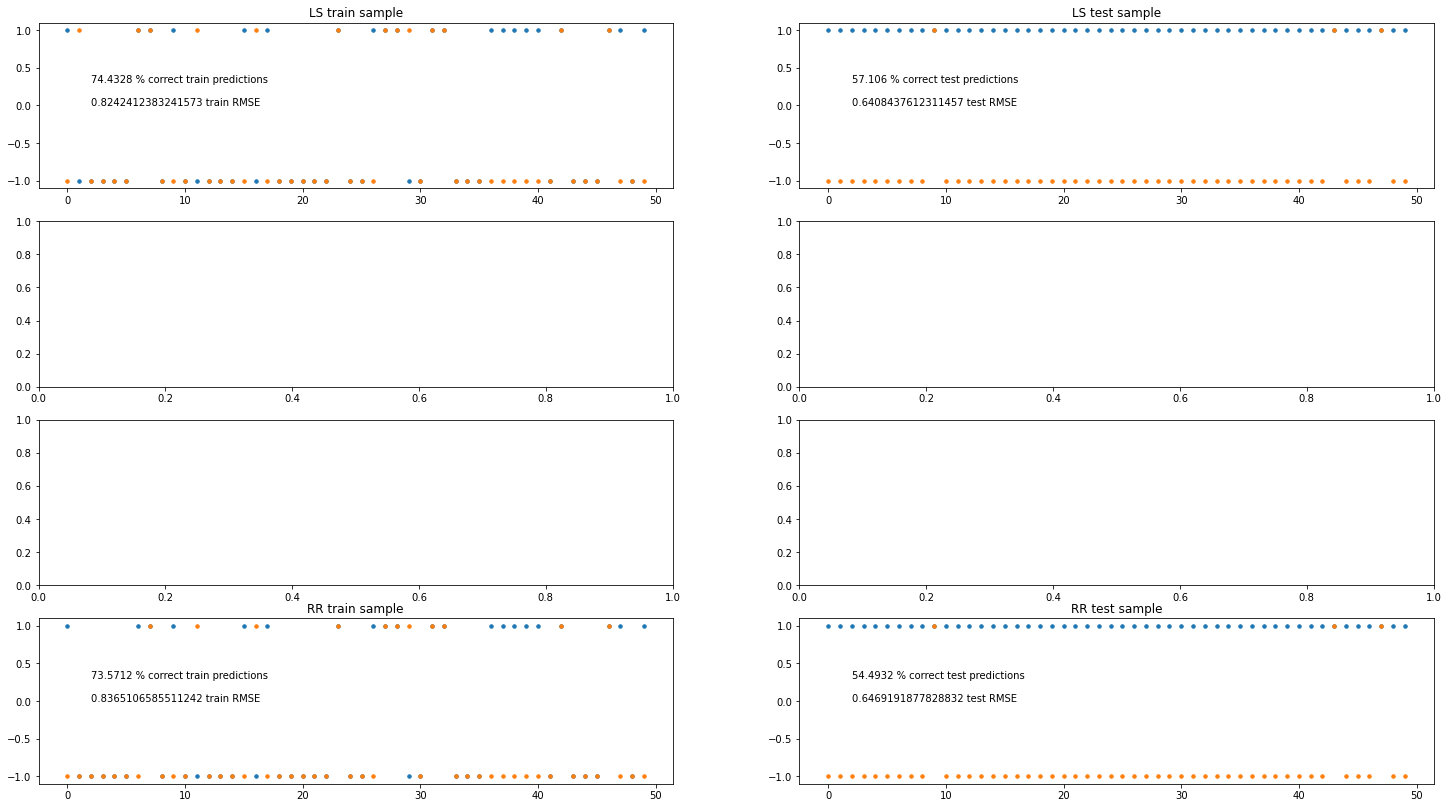

In [108]:
first_obser = range(50)
fig, ax = plt.subplots(4,2,figsize=(25,14))

# TRAIN OBSERVATIONS
ax[0][0].scatter(first_obser,y_train[0:50],s=12)
ax[0][0].scatter(first_obser,f_lse[0:50],s=12)
ax[0][0].title.set_text('LS train sample')
lse_correct = np.sum((f_lse+y_train !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[0][0].text(2,0.3,str(lse_correct)+' % correct train predictions')
ax[0][0].text(2,0,str(loss_train[0])+' train RMSE')


ax[3][0].scatter(first_obser,y_train[0:50],s=12)
ax[3][0].scatter(first_obser,f_rr[0:50],s=12)
ax[3][0].title.set_text('RR train sample')
rr_correct = np.sum((f_rr+y_train !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[3][0].text(2,0.3,str(rr_correct)+' % correct train predictions')
ax[3][0].text(2,0,str(loss_train[3])+' train RMSE')




# TEST OBSERVATIONS

ax[0][1].scatter(first_obser,y_test[0:50],s=12)
ax[0][1].scatter(first_obser,y_pred_lse[0:50],s=12)
ax[0][1].title.set_text('LS test sample')
lse_correct = np.sum((y_pred_lse+y_test !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[0][1].text(2,0.3,str(lse_correct)+' % correct test predictions')
ax[0][1].text(2,0,str(loss_test[0])+' test RMSE')


ax[3][1].scatter(first_obser,y_test[0:50],s=12)
ax[3][1].scatter(first_obser,y_pred_rr[0:50],s=12)
ax[3][1].title.set_text('RR test sample')
rr_correct = np.sum((y_pred_rr+y_test !=0)*1)*100/tx.shape[0] #percentage of correctly defined points
ax[3][1].text(2,0.3,str(rr_correct)+' % correct test predictions')
ax[3][1].text(2,0,str(loss_test[3])+' test RMSE')

plt.show()

**bias and variance**

## 4)	ANALYZE THE ML METHODS:

## 5) CHOSE THE BEST MODEL

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = r'C:/Users/soria/Google Drive/Machine Learning/project1/data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
weights_ridge, loss_gd = ridge_regression(y, tx)

In [ ]:
OUTPUT_PATH = r'C:/Users/soria/Google Drive/Machine Learning/project1/data/predictions_ridge.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights_ridge, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)